In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

In [5]:
# 한글폰트 사용을 위해 설치
# 아래 모듈을 설치하고 불러오면 별도의 한글폰트 설정이 필요 없습니다.
!pip install koreanize-matplotlib

import koreanize_matplotlib

In [6]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

# Mac 의 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

# 폰트가 선명하게 보이기 위해 - 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 그래프가 노트북 안에 보이게 하기 위해
%matplotlib inline

## 1. 꼬리물기 데이터에서 위도경도 경기도에 속하는것만 남기기

In [4]:
data = pd.read_excel("꼬리물기.xlsx")
data

,발생일,위도,경도
0,2022-12-31,36.357430,127.379478
1,2022-12-31,36.357385,127.379582
2,2022-12-31,35.167787,129.133453
3,2022-12-31,37.722977,127.192234
4,2022-12-31,36.492255,127.249486
...,...,...,...
2659,2022-01-08,35.840325,127.131654
2660,2022-01-08,37.586954,126.887000
2661,2022-01-08,37.197287,127.098686
2662,2022-01-08,35.195595,129.108398


In [5]:
filtered_data = data[(data['위도'] >= 36.87226) & (data['위도'] <= 38.300603) & (data['경도'] >= 126.262021) & (data['경도'] <= 127.830532)]
filtered_data

,발생일,위도,경도
3,2022-12-31,37.722977,127.192234
7,2022-12-30,37.474892,127.116714
8,2022-12-30,37.506620,126.901111
9,2022-12-30,37.757487,127.079680
13,2022-12-31,37.209476,127.110450
...,...,...,...
2657,2022-01-05,37.176737,126.936096
2658,2022-01-10,37.456960,126.709142
2660,2022-01-08,37.586954,126.887000
2661,2022-01-08,37.197287,127.098686


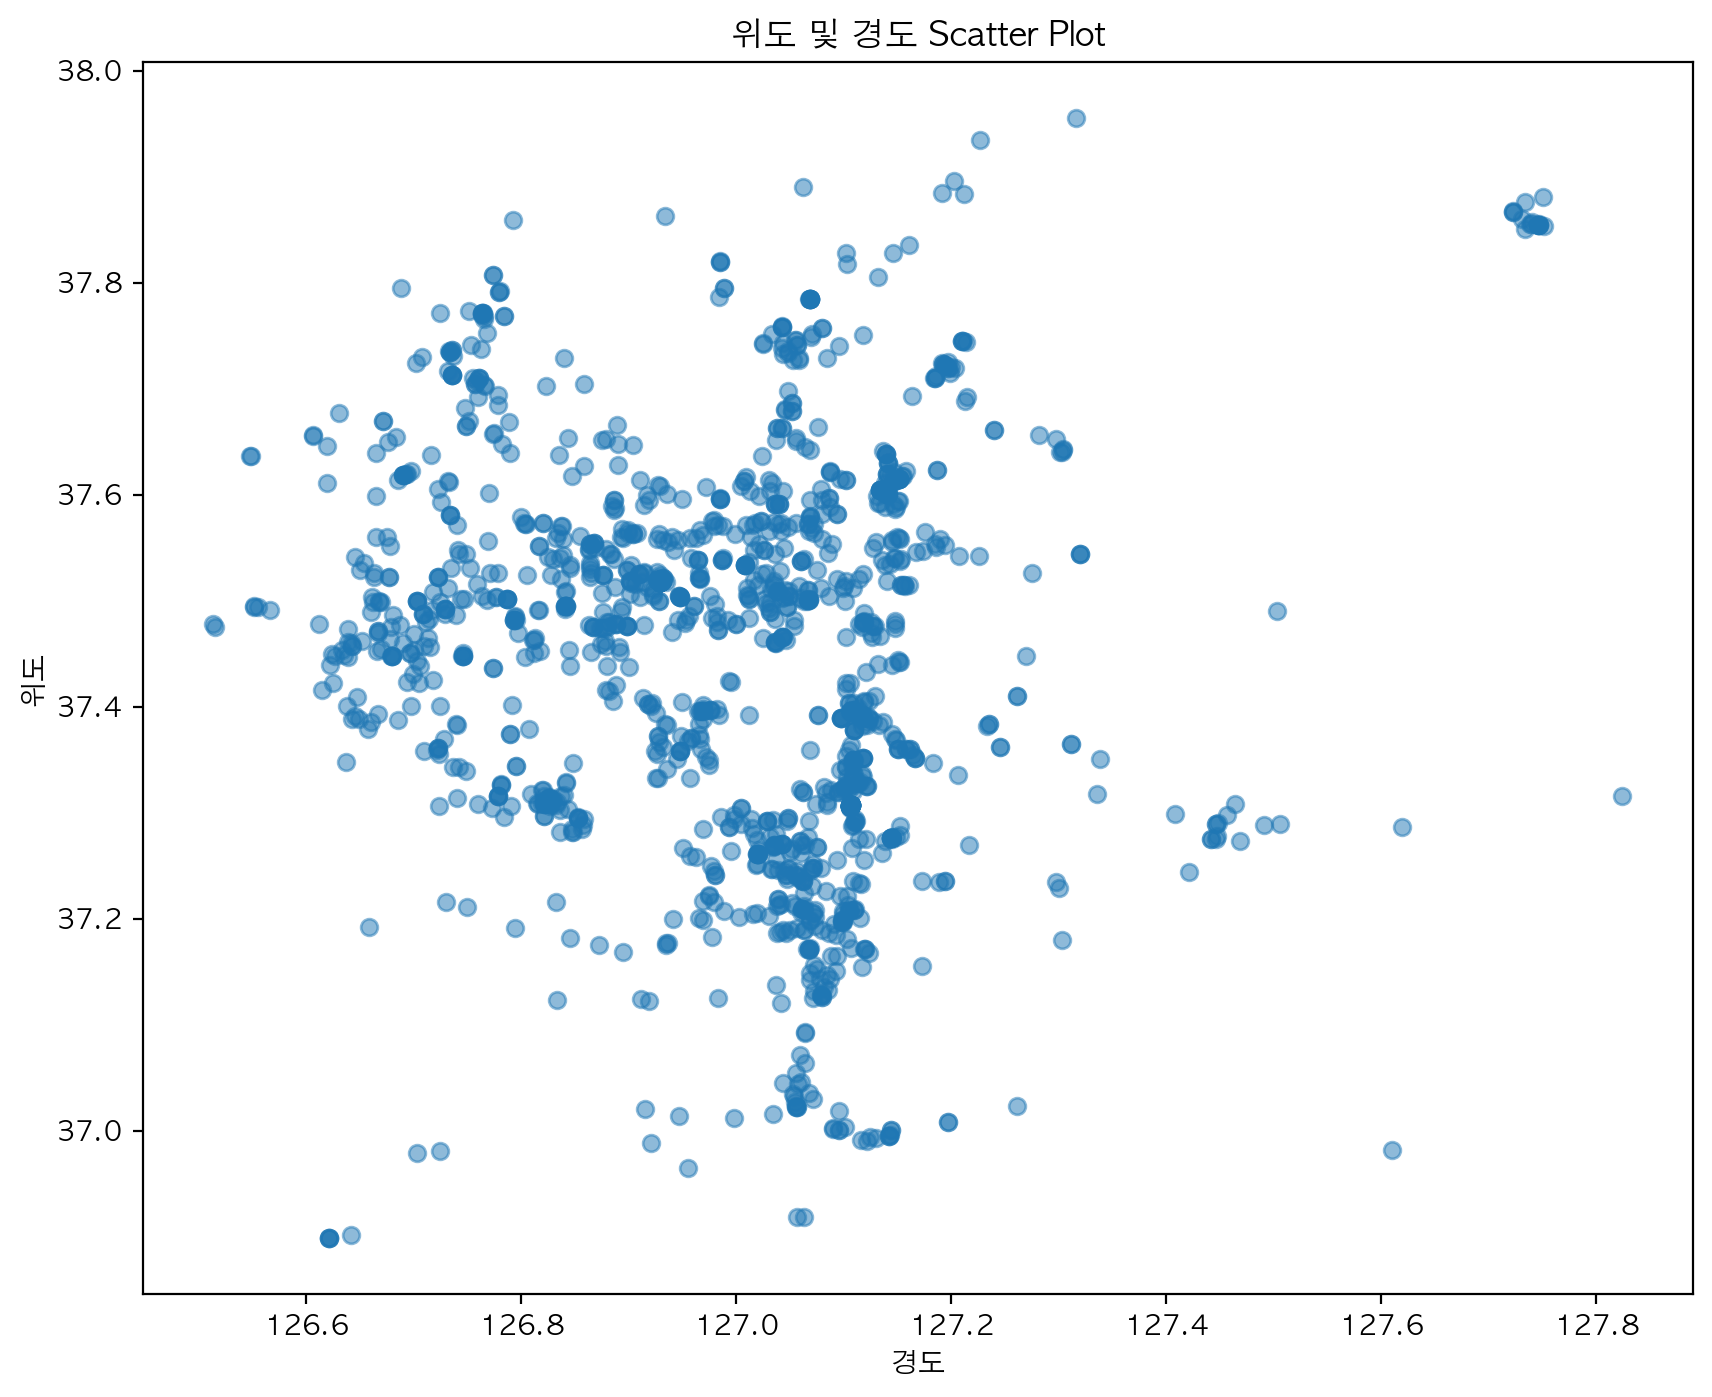

In [6]:
# 단순히 scatter찍어서 확인
import matplotlib.pyplot as plt

# 데이터프레임에서 위도와 경도 컬럼 추출
latitude = filtered_data['위도']
longitude = filtered_data['경도']

# Scatter Plot 생성
plt.figure(figsize=(10, 8))
plt.scatter(longitude, latitude, alpha=0.5, marker='o')

# 그래프 제목과 라벨 설정
plt.title('위도 및 경도 Scatter Plot')
plt.xlabel('경도')
plt.ylabel('위도')

# 그래프 표시
plt.show()

In [7]:
# 지도에 한번 찍어보기 -> 경기도 맞나
import folium

# 지도의 중심 좌표 설정
map_center = [37.5, 126.8]

# Folium 지도 생성
m = folium.Map(location=map_center, zoom_start=8)

# 데이터프레임의 각 행에 대해 루프를 돌면서 마커 생성
for index, row in filtered_data.iterrows():
    folium.Marker([row['위도'], row['경도']]).add_to(m)

# 지도를 HTML 파일로 저장
m.save('map.html')

## 2. 꼬리물기만 하는게 아니라 다른 9개 df도 (위도 경도 제약)경기도만 남기기
## 3. 위도, 경도 열 없애고, 발생횟수 df만들어서 date_df(1년)에 추가

In [8]:
import pandas as pd

# 날짜 범위 생성
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 1. 날짜 범위를 가지고 있는 데이터프레임 생성
date_df = pd.DataFrame({'날짜': date_range})

# 2. 9개의 엑셀 파일 목록
excel_files = ['꼬리물기.xlsx', '불법유턴.xlsx', '불법좌회전.xlsx', '신호위반.xlsx', '역주행.xlsx', '정지선침범.xlsx', '중앙선침범.xlsx', '지정차로위반.xlsx', '진로변경방법위반.xlsx']

# 3. 내가 원하는 위도와 경도 범위 설정 -> 제주도
min_latitude = 33.2243713
max_latitude = 33.5252592
min_longitude = 126.1473303
max_longitude = 126.9881438

# 4. 각 엑셀 파일을 순회하면서 데이터를 추출하고 열을 추가할거임
for file in excel_files:
    df = pd.read_excel(file)
    
    # 4-1.'발생일' 열을 datetime64[ns] 형식으로 변환
    df['발생일'] = pd.to_datetime(df['발생일'])
    
    # 4-2. 위도와 경도 범위 내의 데이터만 선택
    filtered_df = df[(df['위도'] >= min_latitude) & (df['위도'] <= max_latitude) & (df['경도'] >= min_longitude) & (df['경도'] <= max_longitude)]
    
    # 4-3.filtered_df '위도'와 '경도' 열을 삭제
    filtered_df = filtered_df.drop(columns=['위도', '경도'])
    
    # 4-4. 엑셀 파일명에서 .xlsx를 제거하고 column_name으로 사용할거임
    column_name = file.replace('.xlsx', '')
    
    # 4-5.'발생일' 열의 값들을 세서 발생횟수 데이터프레임을 만듭니다.
    date_counts = filtered_df['발생일'].value_counts().reset_index()
    date_counts.columns = ['날짜', column_name]
    
    # 4-6. '날짜' 데이터프레임과 병합
    date_df = date_df.merge(date_counts, on='날짜', how='left')

# 누락된 값은 0으로 채움
date_df = date_df.fillna(0)
df = date_df
# 결과 데이터프레임 출력
df

,날짜,꼬리물기,불법유턴,불법좌회전,신호위반,역주행,정지선침범,중앙선침범,지정차로위반,진로변경방법위반
0,2022-01-01,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0
1,2022-01-02,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0
2,2022-01-03,0.0,3.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0
3,2022-01-04,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-05,0.0,0.0,2.0,3.0,0.0,0.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
360,2022-12-27,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0
361,2022-12-28,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
362,2022-12-29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
363,2022-12-30,0.0,0.0,4.0,4.0,0.0,0.0,2.0,0.0,0.0


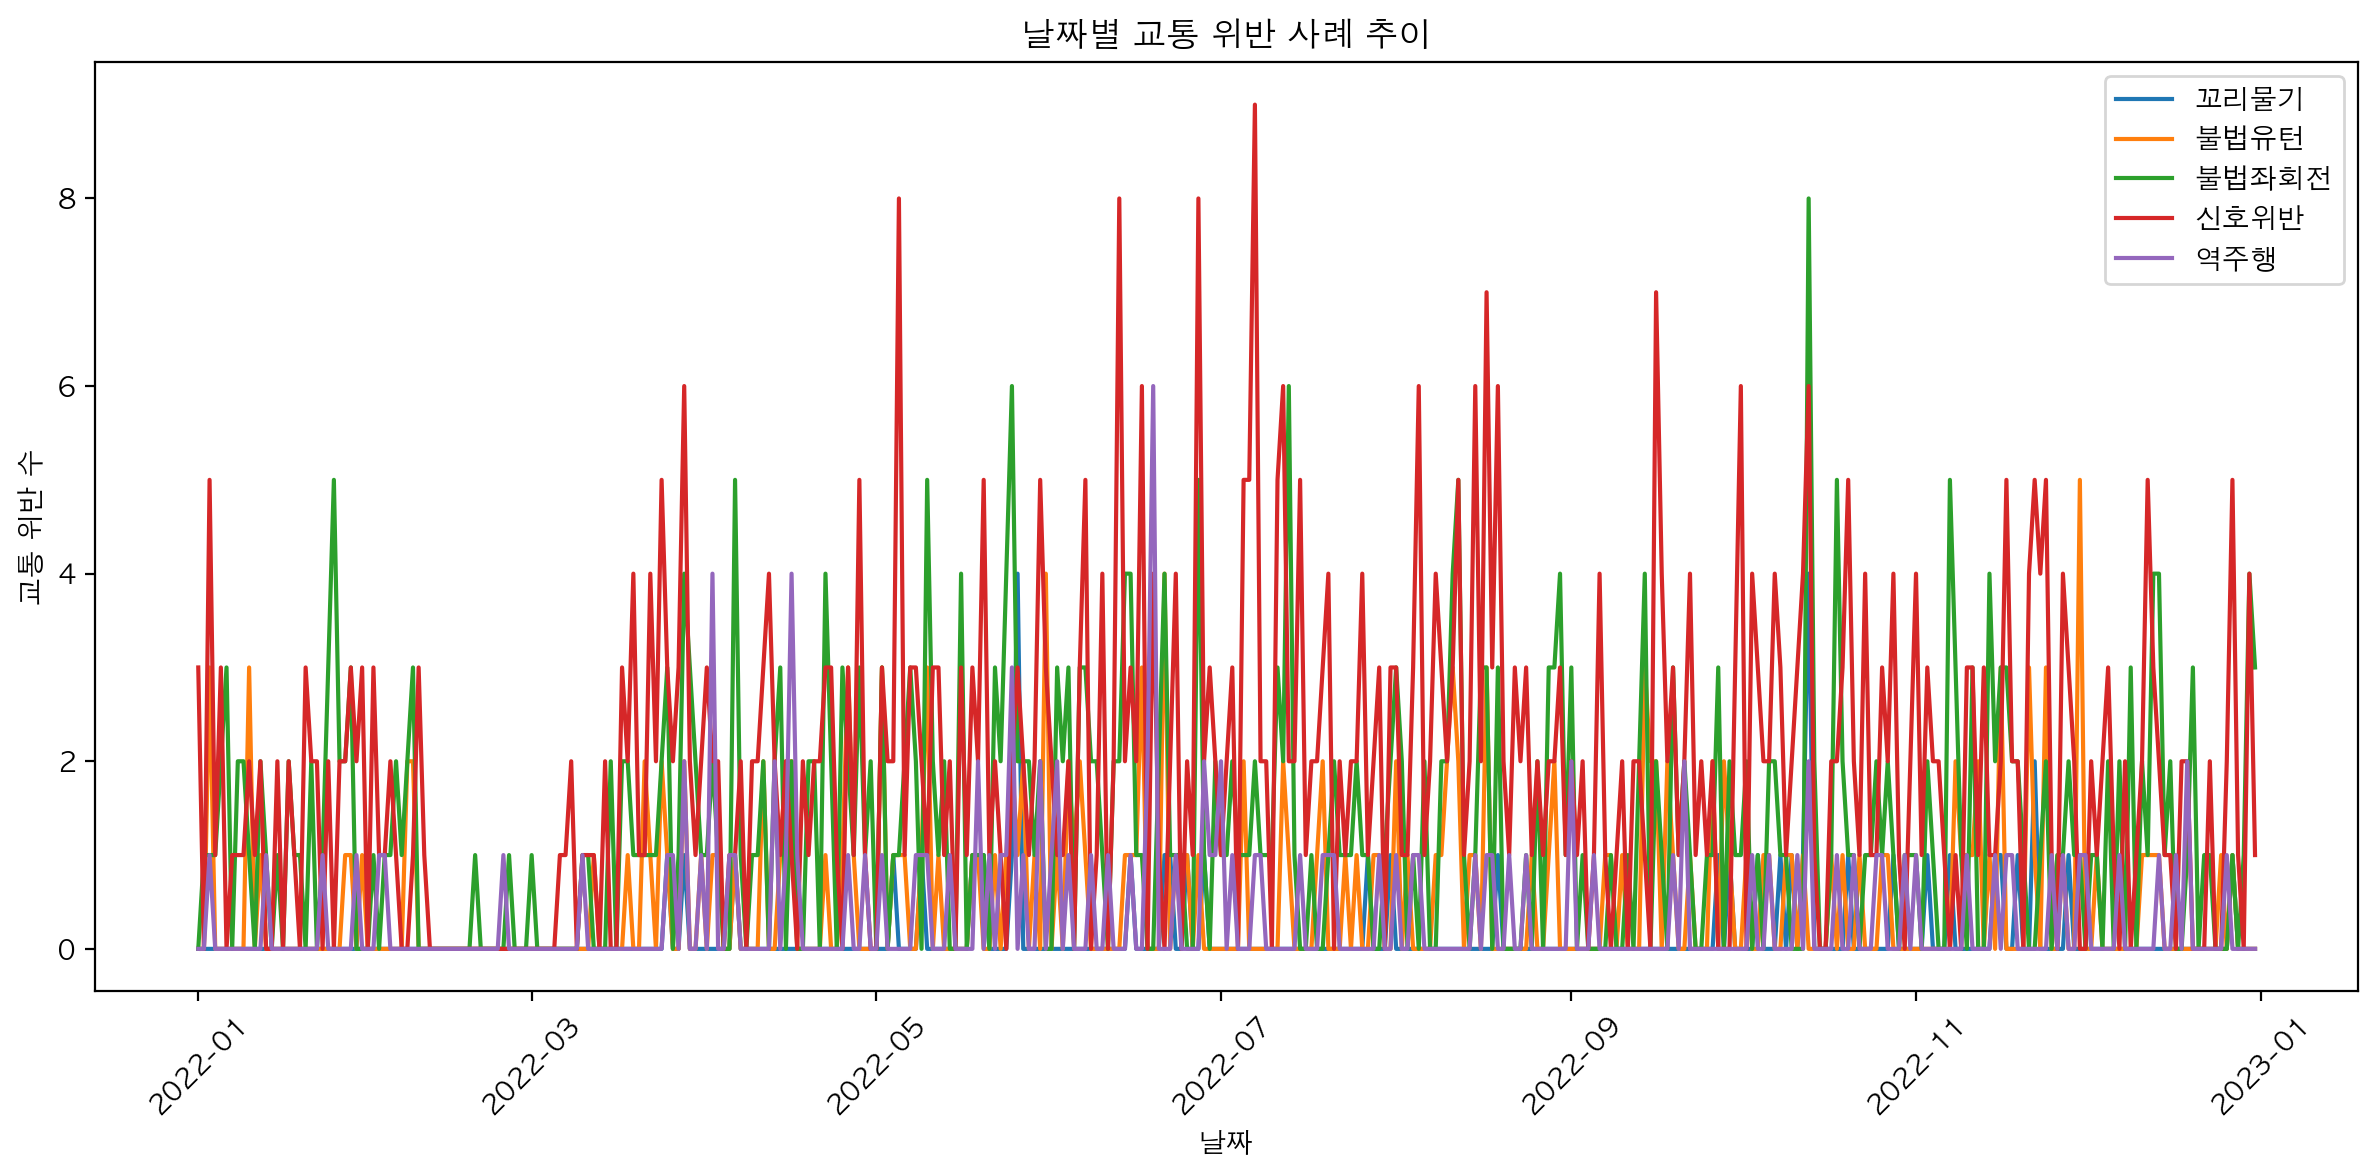

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df['날짜'], df['꼬리물기'], label='꼬리물기')
plt.plot(df['날짜'], df['불법유턴'], label='불법유턴')
plt.plot(df['날짜'], df['불법좌회전'], label='불법좌회전')
plt.plot(df['날짜'], df['신호위반'], label='신호위반')
plt.plot(df['날짜'], df['역주행'], label='역주행')
plt.xlabel('날짜')
plt.ylabel('교통 위반 수')
plt.title('날짜별 교통 위반 사례 추이')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


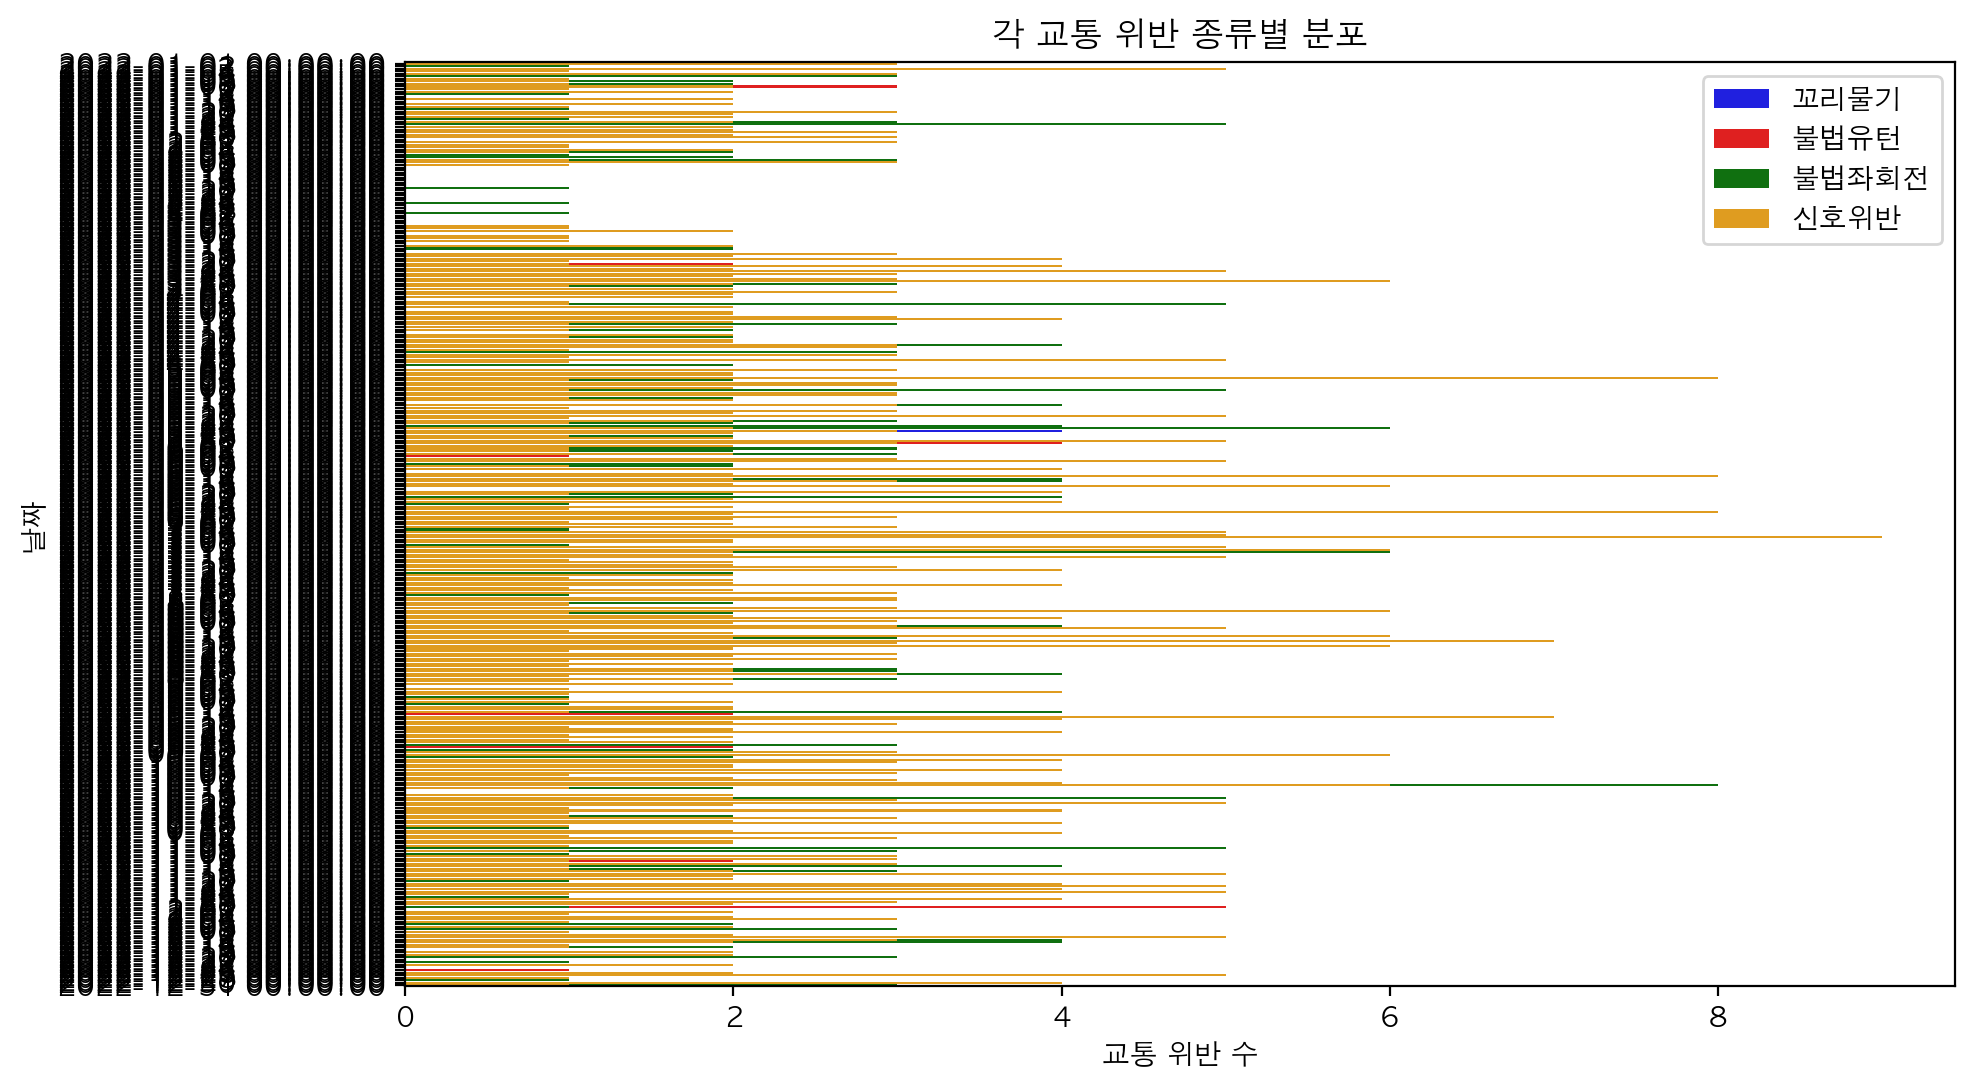

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='꼬리물기', y='날짜', color='blue', label='꼬리물기')
sns.barplot(data=df, x='불법유턴', y='날짜', color='red', label='불법유턴')
sns.barplot(data=df, x='불법좌회전', y='날짜', color='green', label='불법좌회전')
sns.barplot(data=df, x='신호위반', y='날짜', color='orange', label='신호위반')
plt.xlabel('교통 위반 수')
plt.ylabel('날짜')
plt.title('각 교통 위반 종류별 분포')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['꼬리물기', '불법유턴', '불법좌회전', '신호위반', '역주행', '정지선침범', '중앙선침범', '지정차로위반', '진로변경방법위반']])

plt.xlabel('교통 위반 종류')
plt.ylabel('교통 위반 수')
plt.title('교통 위반 종류별 분포 (상자 그림)')
plt.show()


### 엑셀 파일로 저장

In [7]:
# 데이터프레임을 엑셀 파일로 저장
output_file = '제주도9개합침.xlsx'
date_df.to_excel(output_file, index=False)

print(f'Data saved to {output_file}')

Data saved to 제주도9개합침.xlsx
